# Решение задачи кредитного скоринга

In [42]:
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt

from prettytable import PrettyTable

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split

from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

Для работы с данными использую pandas. Первым делом создаю dataframe

In [43]:
df = pd.read_excel("data/Training.xlsb", engine='pyxlsb', index_col="ID")
df.head()

,A,B,C,D,E,F,G,H,I,J,...,P,Q,R,S,T,U,V,W,X,MARKER
ID,,,,,,,,,,,,,,,,,,,,,
1,0.198778,0.099389,0.00,799.90,1.777556,0.888778,13,3.49,Woman,33.750000,...,2 Two,property,No,Works,Yes,Yes,No,Yes,No,0
2,0.043000,0.021264,49.97,173.03,0.384511,0.190143,13,3.49,Woman,33.250000,...,2 Two,otherwise,No,Works,Yes,Yes,Yes,Yes,No,0
3,0.067073,0.067073,0.00,329.90,0.599818,0.599818,13,3.49,Woman,38.583333,...,1 One,property,No,No couple,No,Yes,No,Yes,No,0
4,0.052700,0.052700,0.00,235.65,0.471300,0.471300,13,3.49,Woman,61.250000,...,0 Zero,property,No,No couple,Yes,Yes,Few,Yes,No,0
5,0.141880,0.141880,0.00,634.45,1.268900,1.268900,13,3.49,Woman,48.583333,...,0 Zero,property,No,No couple,Yes,No,No,No,No,0


Функция для красивого отображения необходимых метрик, понадобится ниже.

In [44]:
def get_metrix(y, y_predict):
    cm = confusion_matrix(y, y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    
    metrics_dict = classification_report(y, y_predict, output_dict=True)
    
    table = PrettyTable(["    ", "recall", "precision", "f1-score"])

    table.add_row(
        ["0", metrics_dict['0']['recall'],
         metrics_dict['0']['precision'],
         metrics_dict['0']['f1-score']]
    )
    
    table.add_row(
        ["1", metrics_dict['1']['recall'],
         metrics_dict['1']['precision'],
         metrics_dict['1']['f1-score']]
    )
    
    print(table)
    print(f"roc_auc_score: {roc_auc_score(y, y_predict)}")
    

## EDA и preprocessing

### Обработка категориальных признаков

Сперва проверяю, есть ли пропуски в датасете. Как можно заметить, их нет

In [45]:
nan_rows = df[df.isna().any(axis=1)]
nan_rows.head()

,A,B,C,D,E,F,G,H,I,J,...,P,Q,R,S,T,U,V,W,X,MARKER
ID,,,,,,,,,,,,,,,,,,,,,


Выделяю в наборе данных категориальные признаки, и смотрю, какие уникальные значения они могут принимать.

In [46]:
categorical_columns = [
    "I", "K", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X"
]

for column in categorical_columns:
    print(df[column].unique())

['Woman' 'Man']
['Mogilev region' 'Minsk region' 'Vitebsk region' 'Brest region' 'Minsk'
 'Grodno region' 'Gomel region']
['NE employee' 'Pensioner' 'Head/Deputy head (organiz.)'
 'Head/Deputy head (division)' 'Enterpreneur']
['Secondary education (plus special education)'
 'Higher education (one or more)' 'Incomplete higher education'
 'Primary or lower secondary education']
['Married' 'Divorced/widow' 'Single/unmarried' 'Cohabitation']
['2 Two' '1 One' '0 Zero' '3 Three' 'More than 3']
['property' 'otherwise' 'rent/hire']
['No' 'Yes']
['Works' 'No couple' 'Pensioner' 'Unemployed' 'Student']
['Yes' 'No']
['Yes' 'No']
['No' 'Yes' 'Few']
['Yes' 'No']
['No' 'Yes']


Проверял уникальные значения, тк в данные могли быть записаны мусорные значения, например, тестовое "None"

Затем присваиваю значения категориальных признаков в числовую последовательность. Для каждого уникального значения, свое число, Это нужно для обучения модели.

In [47]:
for key in categorical_columns:
    df[key] = pd.Categorical(df[key]).codes
    
df.head()

,A,B,C,D,E,F,G,H,I,J,...,P,Q,R,S,T,U,V,W,X,MARKER
ID,,,,,,,,,,,,,,,,,,,,,
1,0.198778,0.099389,0.00,799.90,1.777556,0.888778,13,3.49,1,33.750000,...,2,1,0,4,1,1,1,1,0,0
2,0.043000,0.021264,49.97,173.03,0.384511,0.190143,13,3.49,1,33.250000,...,2,0,0,4,1,1,2,1,0,0
3,0.067073,0.067073,0.00,329.90,0.599818,0.599818,13,3.49,1,38.583333,...,1,1,0,0,0,1,1,1,0,0
4,0.052700,0.052700,0.00,235.65,0.471300,0.471300,13,3.49,1,61.250000,...,0,1,0,0,1,1,0,1,0,0
5,0.141880,0.141880,0.00,634.45,1.268900,1.268900,13,3.49,1,48.583333,...,0,1,0,0,1,0,1,0,0,0


### Нормирование данных

Затем провожу нормирование данных с помощью MinMaxScaler, делаю так, чтобы значения в столбцах изменялись от 0 до 1. 

Это нужно, чтобы все веса в моделях присваивались оптимально и один признак с большей размерностью не доминировал над остальными

In [48]:
scale = MinMaxScaler()

for col in df.columns:
    if col == 'MARKER':
        continue

    df[col] = scale.fit_transform(df[col].values.reshape(-1, 1))

df.head()

,A,B,C,D,E,F,G,H,I,J,...,P,Q,R,S,T,U,V,W,X,MARKER
ID,,,,,,,,,,,,,,,,,,,,,
1,0.028126,0.113713,0.000000,0.151529,0.050303,0.085846,0.5,0.997143,1.0,0.290323,...,0.50,0.5,0.0,1.0,1.0,1.0,0.5,1.0,0.0,0
2,0.006084,0.024327,0.018629,0.024864,0.010881,0.018365,0.5,0.997143,1.0,0.278937,...,0.50,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0
3,0.009490,0.076739,0.000000,0.056561,0.016974,0.057936,0.5,0.997143,1.0,0.400380,...,0.25,0.5,0.0,0.0,0.0,1.0,0.5,1.0,0.0,0
4,0.007457,0.060294,0.000000,0.037517,0.013337,0.045522,0.5,0.997143,1.0,0.916509,...,0.00,0.5,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0
5,0.020075,0.162328,0.000000,0.118098,0.035908,0.122563,0.5,0.997143,1.0,0.628083,...,0.00,0.5,0.0,0.0,1.0,0.0,0.5,0.0,0.0,0


### Матрица корреляции

Вывожу матрицу корреляции. Она показывает как признаки коррелируют между собой и между целевой переменной. Это нужно для уменьшения размерности.

Например, если признаки сильно коррелируют между собой, то нет необходимости оставлять по итогу оба признака. И напротив, если признак практически не коррелирует с целевой переменной, то его там же можно убрать из обучающей выборки

In [49]:
corr_matrix = df.corr()

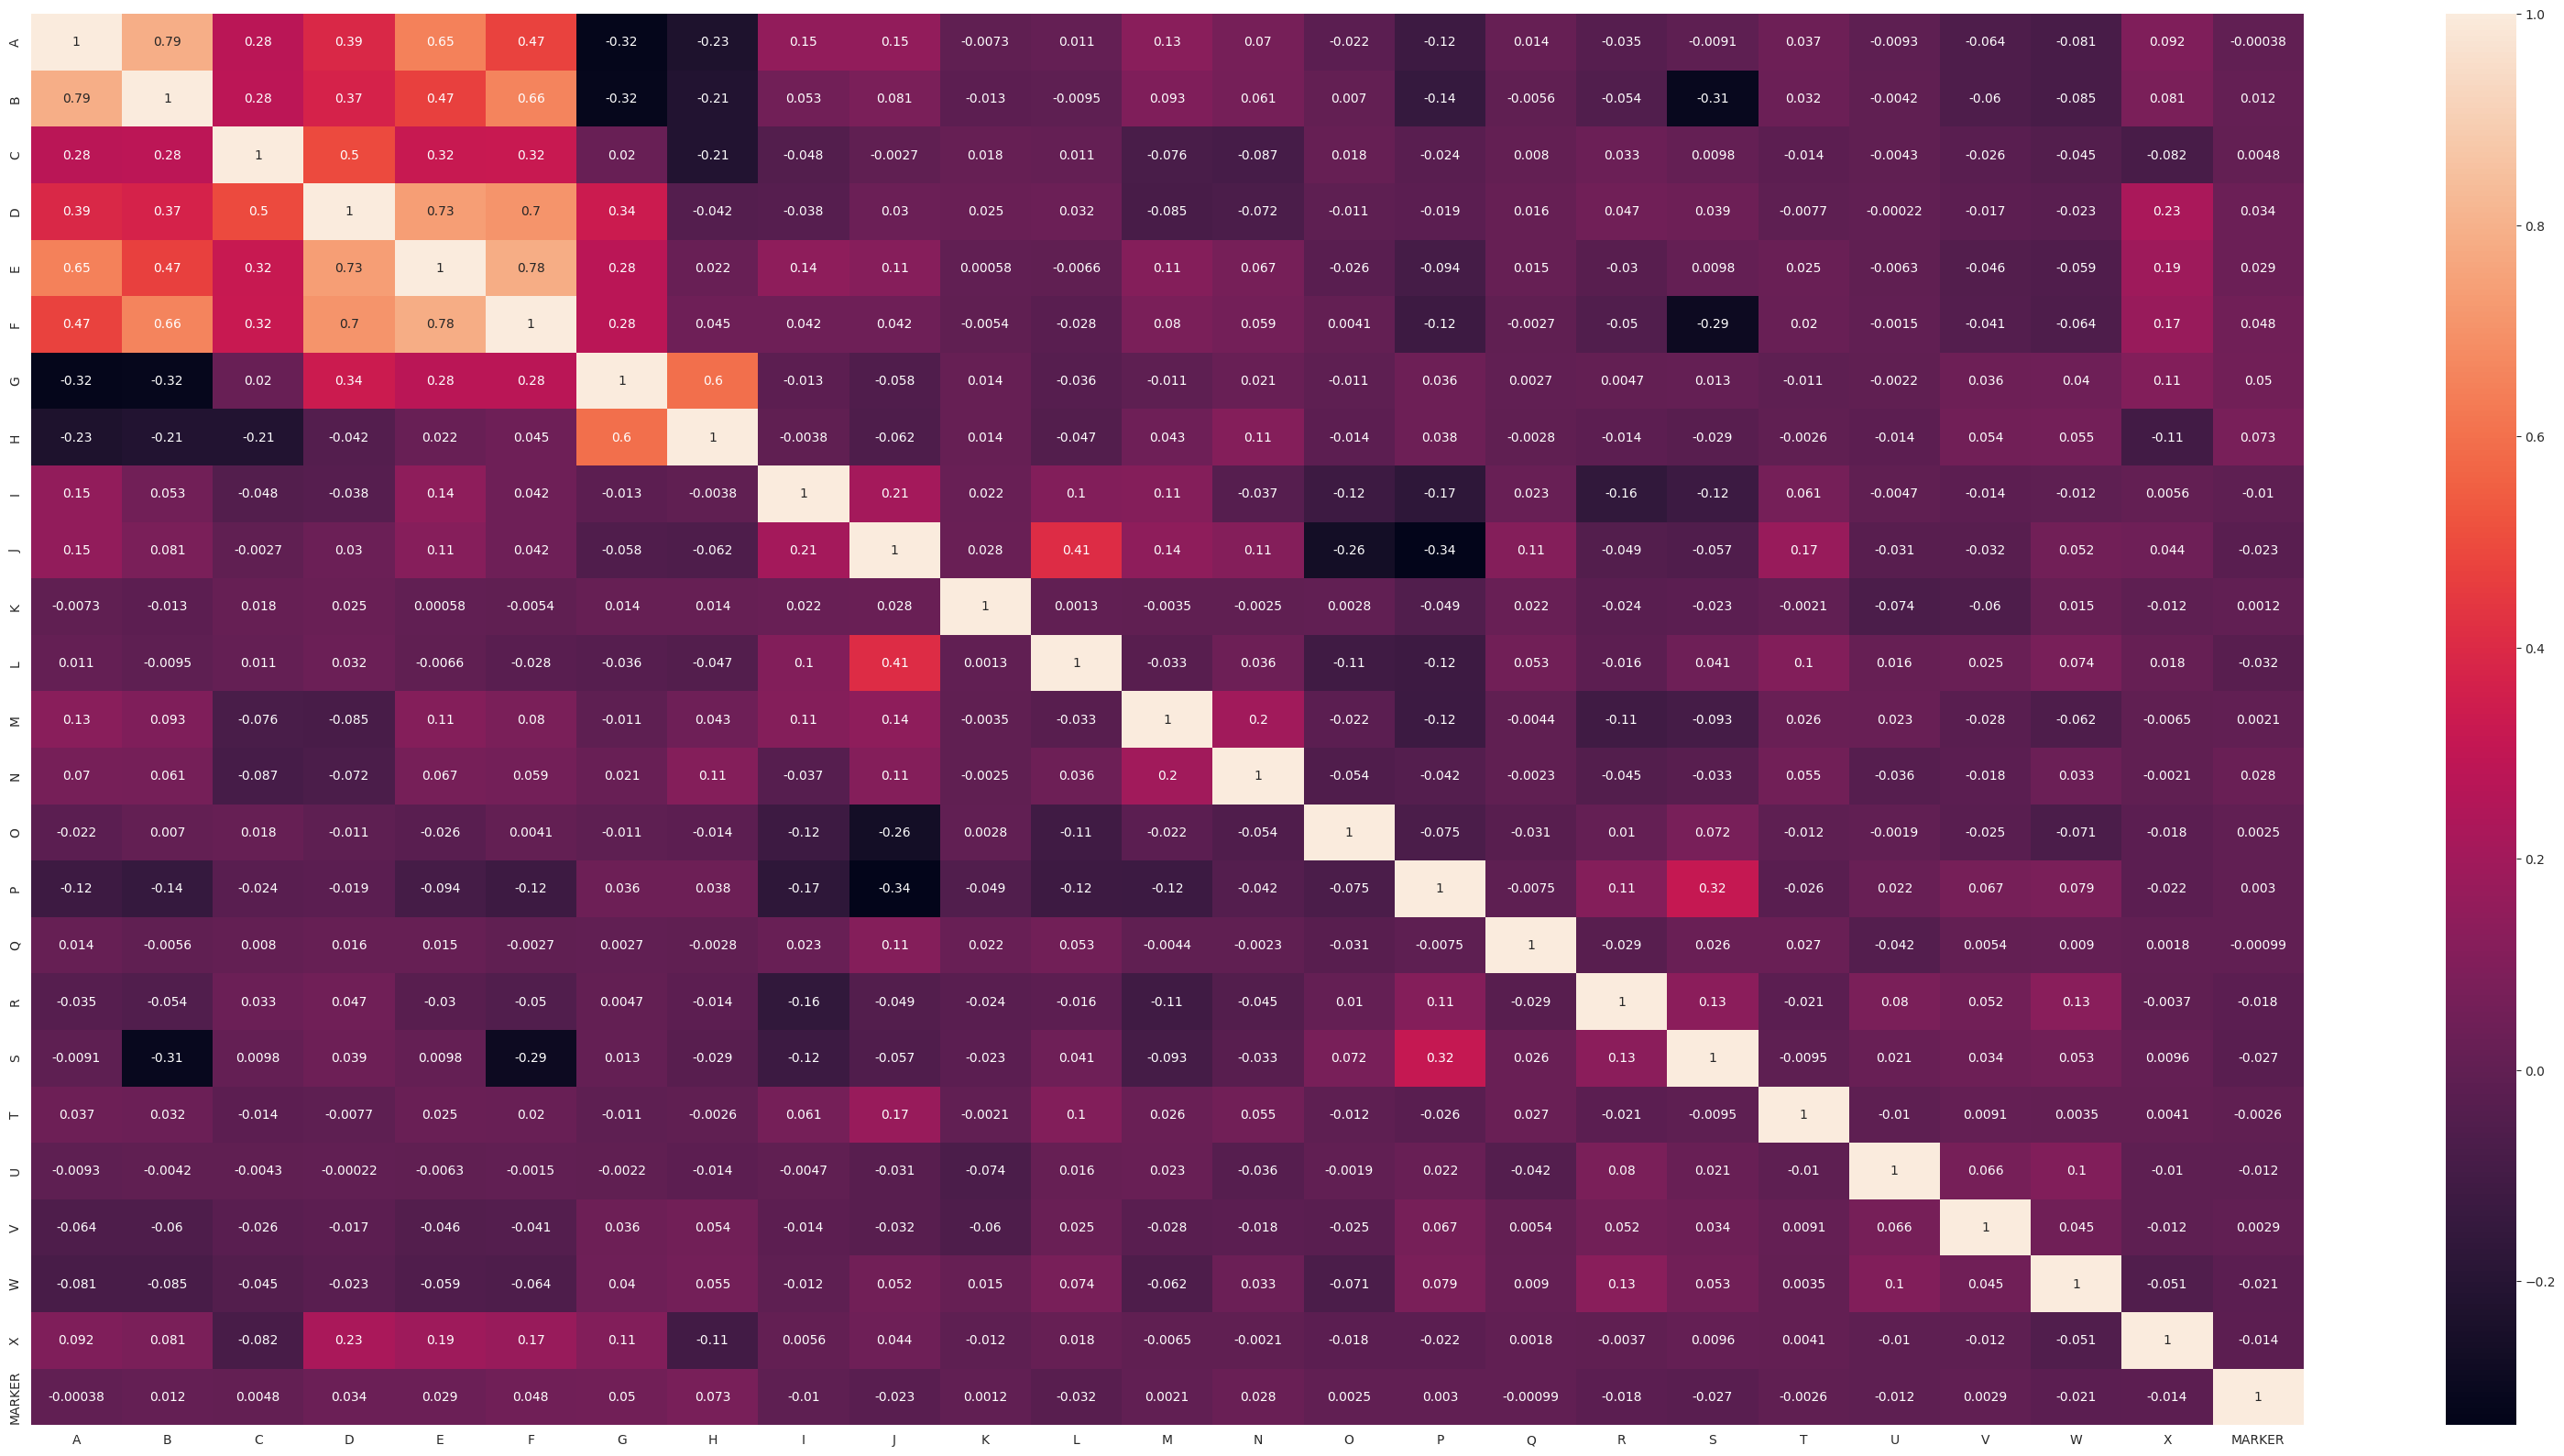

In [50]:
plt.figure(figsize=(40, 20))
sn.heatmap(corr_matrix, annot=True)

plt.show()

Как можно заметить максимальная корреляция между признаками выходит 0.79, что не достаточно, чтобы убирать признак. Большой корреляцией считается от 0.9 - 1.0. Здесь нет необходимости убирать признаки.

Теперь вывожу признаки в порядке убывания корреляции с целевой переменной.

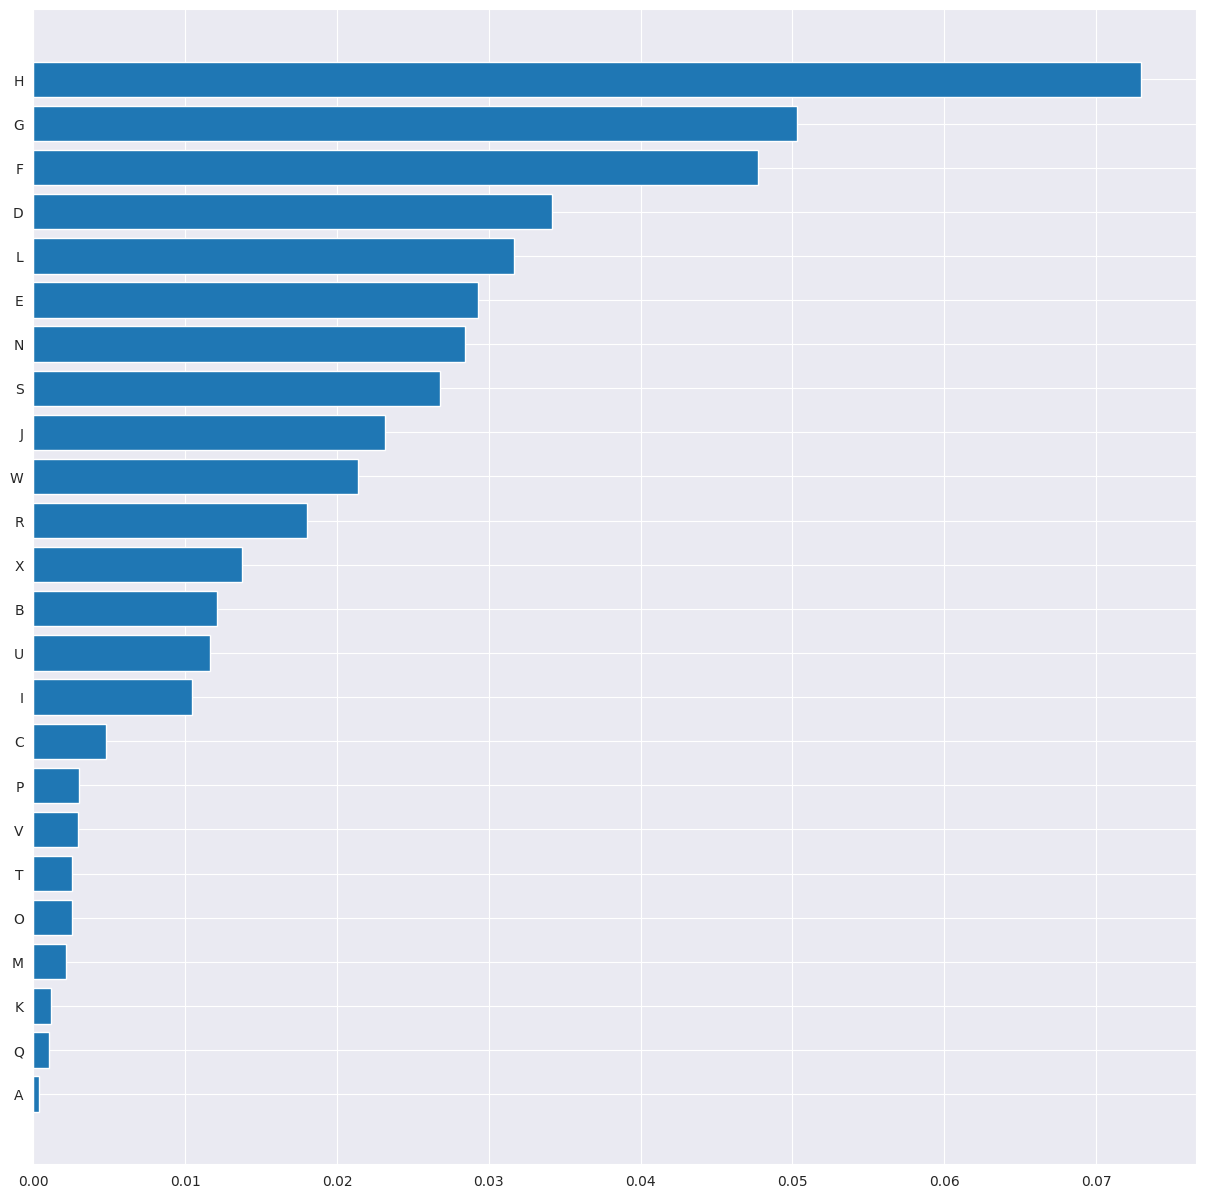

In [51]:
plt.figure(figsize=(15, 15))

largest_corr = corr_matrix['MARKER'].abs().sort_values().drop('MARKER')
plt.barh(largest_corr.index, largest_corr)

plt.show()

Убираю признаки, которые коррелируют с целевой переменной меньше чем на 0.11.

Выбрал не округленное число, тк признак "I" так же мало значителен и при его удалении точность выходила выше.

In [52]:
insignificant_features = []

for features, corr_value in zip(largest_corr.index, largest_corr):    
    if corr_value < 0.011:
        insignificant_features.append(features)
        
insignificant_features

['A', 'Q', 'K', 'M', 'O', 'T', 'V', 'P', 'C', 'I']

In [53]:
df.drop(insignificant_features, axis=1, inplace=True)
df.head()

,B,D,E,F,G,H,J,L,N,R,S,U,W,X,MARKER
ID,,,,,,,,,,,,,,,
1,0.113713,0.151529,0.050303,0.085846,0.5,0.997143,0.290323,0.244444,1.0,0.0,1.0,1.0,1.0,0.0,0
2,0.024327,0.024864,0.010881,0.018365,0.5,0.997143,0.278937,0.011111,1.0,0.0,1.0,1.0,1.0,0.0,0
3,0.076739,0.056561,0.016974,0.057936,0.5,0.997143,0.400380,0.131481,1.0,0.0,0.0,1.0,1.0,0.0,0
4,0.060294,0.037517,0.013337,0.045522,0.5,0.997143,0.916509,0.088889,1.0,0.0,0.0,1.0,1.0,0.0,0
5,0.162328,0.118098,0.035908,0.122563,0.5,0.997143,0.628083,0.088889,1.0,0.0,0.0,0.0,0.0,0.0,0


Еще раз вывожу матрицу корреляции

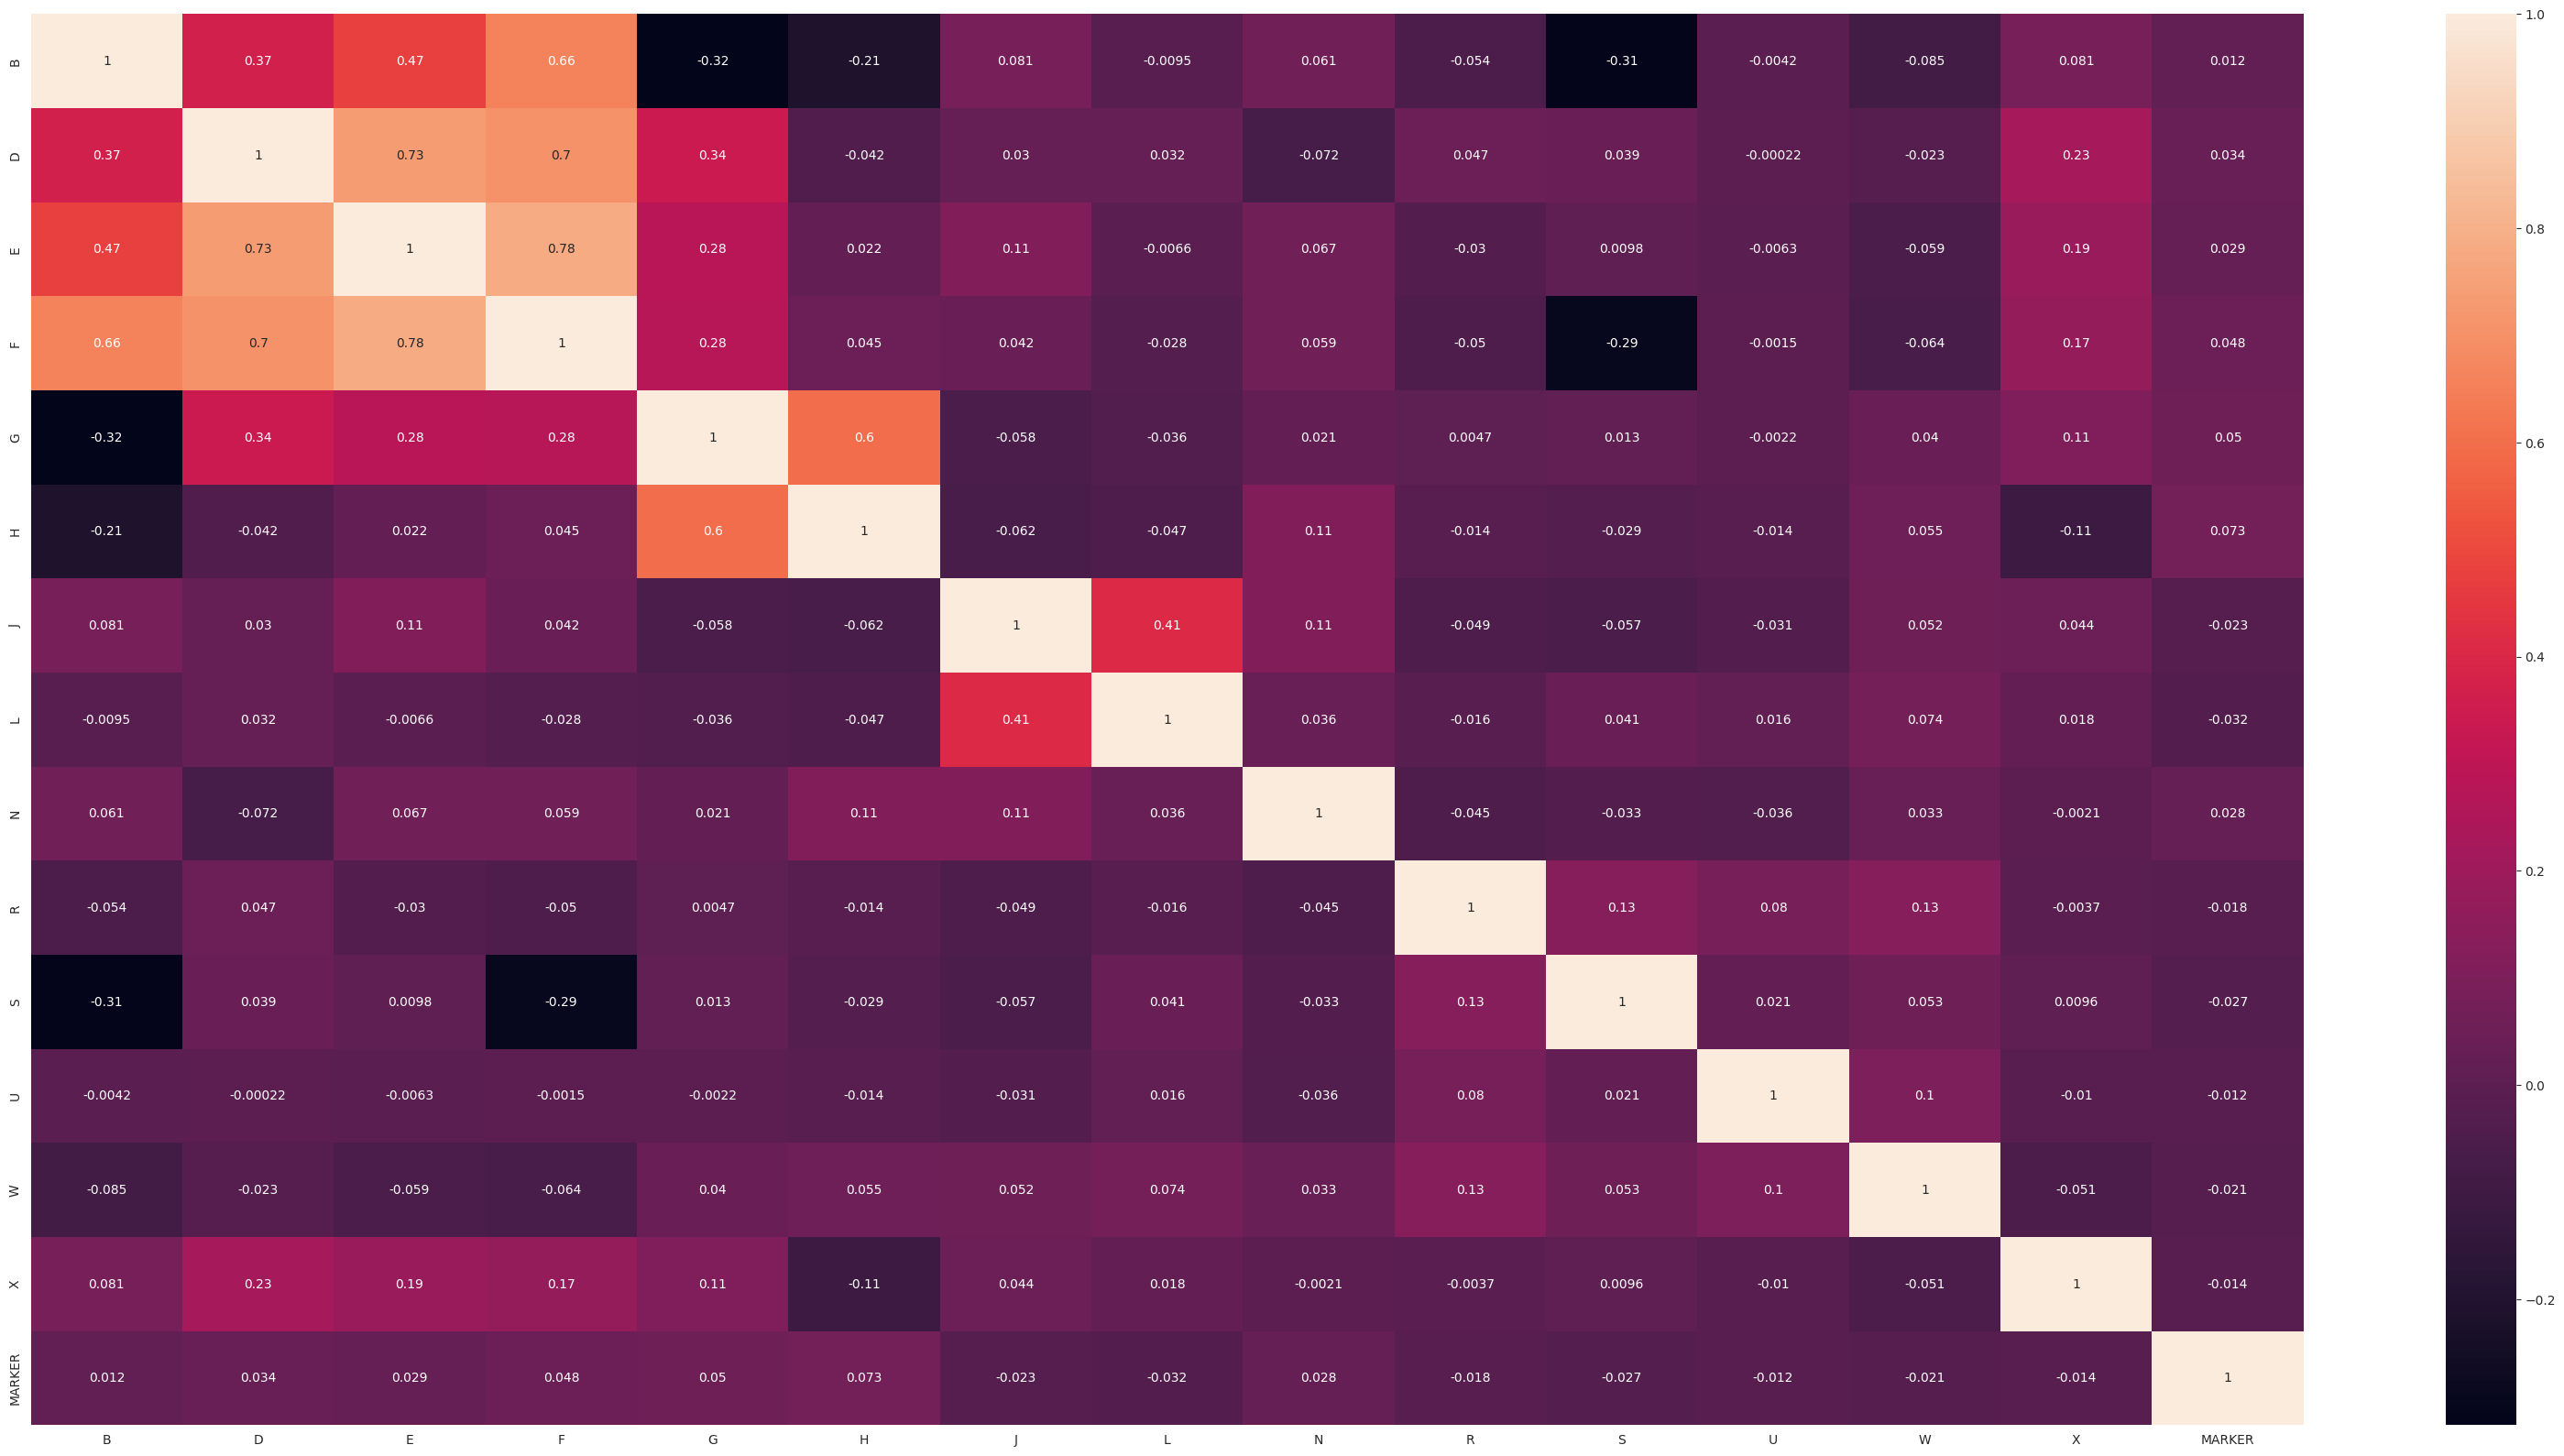

In [54]:
corr_matrix = df.corr()

plt.figure(figsize=(40, 20))
sn.heatmap(corr_matrix, annot=True)

plt.show()

### Дисбаланс классов

Отделяю признаки от целевой переменной и вывожу количество случаев с дефолтом и без 

In [55]:
columns_len = df.columns.shape[0]

X = df.iloc[:, 0:columns_len - 1]
Y = df.iloc[:, columns_len - 1]

default_count = Y[Y == 1].shape[0]
normal_count = Y[Y == 0].shape[0]

normal_count, default_count

(89392, 342)

Как можно заметить, количество случаев без дефолта сильно больше количества с дефолтом, а значит у нас случай дисбаланса классов.

Разбиваю набор данный на тестовою и тренировочную выборку. Для тестовых данных использую 20% от общего числа данных. Указываю random_state, чтобы результаты были воспроизводимы.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_test.reset_index(inplace=True)
y_test = pd.DataFrame(y_test.values)

X_test.drop('ID', axis=1, inplace=True)

Существует несколько способов решить проблему дисбаланса классов. В данном случае, я использую Undersampler, те случайным образом уменьшаю количество примеров без дефолта до количества примеров с дефолтом. 

Позже еще рассмотрю метод Oversampling, те увелечения количества примеров с дефолтом.

In [57]:
oversample = RandomUnderSampler(random_state=20)
X_train_sample, y_train_sample = oversample.fit_resample(X_train, y_train)

default_count = y_train_sample[y_train_sample == 1].shape[0]
normal_count = y_train_sample[y_train_sample == 0].shape[0]

normal_count, default_count

(283, 283)

Как можно заметить, теперь нет дисбаланса классов.

## Обучение модели

Для первого примера, рассмотрю модель градиентного бустинга, и выведу метрики. 

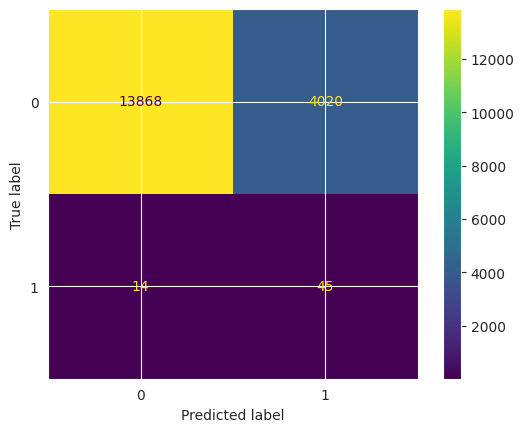

+------+--------------------+---------------------+----------------------+
|      |       recall       |      precision      |       f1-score       |
+------+--------------------+---------------------+----------------------+
|  0   | 0.7752683363148479 |  0.9989914997838928 |  0.8730248662259994  |
|  1   | 0.7627118644067796 | 0.01107011070110701 | 0.021823472356935016 |
+------+--------------------+---------------------+----------------------+
roc_auc_score: 0.7689901003608138


In [58]:
model = LGBMClassifier(
    random_state=42, force_row_wise=True, verbose=-100
)

model.fit(X_train_sample, y_train_sample)

y_predict_test = model.predict(X_test)

get_metrix(y_test, y_predict_test)

Основной метрикой кредитного скоринга является ROC AUC метрика, однако и другие метрики, такие как recall, precision и F1 тоже важны.

В данном случае мы получили значения roc_auc равной 0.70, что нормальный результат, однако его можно улучшить.

Однако можно справедлива заметить, что precision и, соответственно, и f1 для случаев с дефолтом вышли низкими. Это значит что в процентном соотношении, количество клиентов ушедших в дефолт сильно меньше, чем таких определила модель.

Однако исходя из метрик recall и roc_auc модель в целом справляется со своей задачей, а именно минимизировать потери банка в случае дефолта клиента, но при этом максимизировать его доходи от выдачи кредитов, те не поголовно отказывать в кредитах.

Попробую увеличить точность подели с подбором гиперпараметров и моделей. А так же попробую определить, какой метод отработал лучше UnderSampler или OverSampler

In [59]:
sampling_methods = {
    "under_sampler": RandomUnderSampler(random_state=20), 
    "over_sampler": RandomOverSampler(random_state=20),    
}

model_list = {
    "random_forest": RandomForestClassifier(random_state=42),
    "logistic_regression": LogisticRegression(random_state=42),
    "lgbm_gradient_boosting": LGBMClassifier(random_state=42, force_row_wise=True, verbose=-100)
}

random_forest_param = {
    'n_estimators':[5, 10, 20, 30, 50],
    'max_depth':[2, 5, 10, 20, 30],
}

logistic_regression_param = [
    {'solver': ['lbfgs'], 'penalty': ['l2'], 'C':[0.001, 0.01, 0.1, 1, 10, 100], 'class_weight': ['balanced', None]},
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C':[0.001, 0.01, 0.1, 1, 10, 100], 'class_weight': ['balanced', None]},
]

gradient_boosting_param = {
    'n_estimators':[5, 10, 20, 30],
    'num_leaves':[5, 10, 20, 30],
    'max_depth':[2, 5, 10, 20],
}

model_param = {
    "random_forest": random_forest_param,
    "logistic_regression": logistic_regression_param,
    "lgbm_gradient_boosting": gradient_boosting_param
}

dataframe_result = pd.DataFrame(columns=["sampling_method", "model_name", "0_recall", "1_recall", "0_precision", "1_precision", "0_f1", "1_f1", "roc_auc", "params"])

for sampling_method, sampling in sampling_methods.items():
    
    X_train_sample, y_train_sample = sampling.fit_resample(X_train, y_train)
    
    for model_name, model in model_list.items():
        
        clf = GridSearchCV(model, param_grid=model_param[model_name], scoring="roc_auc")
        best_clf = clf.fit(X_train_sample, y_train_sample)

        y_predict_test = best_clf.predict(X_test)
        
        metrics = classification_report(y_test, y_predict_test, output_dict=True)
        
        msg_dict = {
            "sampling_method": sampling_method,
            "model_name": model_name,
            "0_recall": metrics['0']['recall'],
            "1_recall": metrics['1']['recall'],
            "0_precision": metrics['0']['precision'],
            "1_precision": metrics['1']['precision'],
            "0_f1": metrics['0']['f1-score'],
            "1_f1": metrics['1']['f1-score'],
            "roc_auc": roc_auc_score(y_test, y_predict_test),
            "params": clf.best_params_
        }

        dataframe_result.loc[len(dataframe_result)] = msg_dict
        
        
dataframe_result.head(20)

,sampling_method,model_name,0_recall,1_recall,0_precision,1_precision,0_f1,1_f1,roc_auc,params
0,under_sampler,random_forest,0.780803,0.830508,0.999285,0.012343,0.876636,0.024324,0.805656,"{'max_depth': 20, 'n_estimators': 30}"
1,under_sampler,logistic_regression,0.779797,0.830508,0.999284,0.012287,0.876001,0.024215,0.805152,"{'C': 10, 'class_weight': None, 'penalty': 'l2..."
2,under_sampler,lgbm_gradient_boosting,0.771523,0.745763,0.998914,0.010651,0.870616,0.021002,0.758643,"{'max_depth': 5, 'n_estimators': 30, 'num_leav..."
3,over_sampler,random_forest,0.997876,0.033898,0.996817,0.050000,0.997346,0.040404,0.515887,"{'max_depth': 20, 'n_estimators': 30}"
4,over_sampler,logistic_regression,0.787120,0.813559,0.999219,0.012448,0.880578,0.024521,0.800340,"{'C': 100, 'class_weight': 'balanced', 'penalt..."
5,over_sampler,lgbm_gradient_boosting,0.885845,0.661017,0.998739,0.018741,0.938911,0.036449,0.773431,"{'max_depth': 20, 'n_estimators': 30, 'num_lea..."


После получения результатов видно, что random_forest справился лучше всего с under_sampler и параметрами {'max_depth': 20, 'n_estimators': 30}

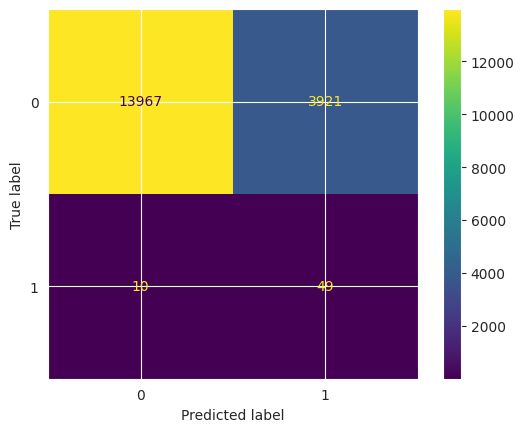

+------+--------------------+---------------------+----------------------+
|      |       recall       |      precision      |       f1-score       |
+------+--------------------+---------------------+----------------------+
|  0   | 0.7808027728085868 |  0.9992845388853115 |  0.8766358073120979  |
|  1   | 0.8305084745762712 | 0.01234256926952141 | 0.024323653512037725 |
+------+--------------------+---------------------+----------------------+
roc_auc_score: 0.805655623692429


In [60]:
sampling = RandomUnderSampler(random_state=20)

X_train_sample, y_train_sample = sampling.fit_resample(X_train, y_train)

model = RandomForestClassifier(random_state=42, max_depth=20, n_estimators=30)
model.fit(X_train_sample, y_train_sample)

y_predict_test = model.predict(X_test)

get_metrix(y_test, y_predict_test)

Финальный результат вышел 0.81, что является хорошим результатом.